In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Select device (use GPU if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
# Load CSV files (ensuring no headers)
data_dir = "shared leader-follower data/data11/4/"
rho_l = pd.read_csv(os.path.join(data_dir, "rho_l_values.csv"), header=None).values[:602, :]
rho_f = pd.read_csv(os.path.join(data_dir, "rho_f_values.csv"), header=None).values[:602, :]
t_values = pd.read_csv(os.path.join(data_dir, "t_values.csv")).values[:602, 0]
x_values = np.linspace(0, 40, 101)  # Assume uniform x spacing

In [4]:
# Generate space-time grid
T, X = np.meshgrid(t_values, x_values, indexing='ij')

# Reshape into (x, t, rho_l, rho_f) format
train_data = np.column_stack([X.ravel(), T.ravel(), rho_l.ravel(), rho_f.ravel()])
train_df = pd.DataFrame(train_data, columns=['x', 't', 'rho_l', 'rho_f'])

# Convert data to PyTorch tensors
x_train = torch.tensor(train_df["x"].values, dtype=torch.float32).view(-1, 1).to(device)
t_train = torch.tensor(train_df["t"].values, dtype=torch.float32).view(-1, 1).to(device)
rho_l_train = torch.tensor(train_df["rho_l"].values, dtype=torch.float32).view(-1, 1).to(device)
rho_f_train = torch.tensor(train_df["rho_f"].values, dtype=torch.float32).view(-1, 1).to(device)

In [5]:
# Define the PINN Model with 8 Trainable Parameters
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output: [rho_l, rho_f]
        )

        # Trainable PDE parameters (8 parameters)
        self.D_l = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        self.D_f = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.35, dtype=torch.float32))
        self.chi = nn.Parameter(torch.tensor(5, dtype=torch.float32))
        self.alpha_l = nn.Parameter(torch.tensor(0.4, dtype=torch.float32))
        self.alpha_f = nn.Parameter(torch.tensor(0.6, dtype=torch.float32))
        self.alpha_fl = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

In [6]:
# Compute gradients
def compute_gradients(y, x):
    """Compute first and second order derivatives of y with respect to x."""
    y_x = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x, torch.ones_like(y_x), create_graph=True)[0]
    return y_x, y_xx

In [7]:
# Compute PDE derivatives
def compute_derivatives(model, x, t):
    """Compute necessary derivatives for PINN loss calculation."""
    rho_l, rho_f = model(x, t).split(1, dim=1)
    rho_l_t = torch.autograd.grad(rho_l, t, torch.ones_like(rho_l), create_graph=True)[0]
    rho_f_t = torch.autograd.grad(rho_f, t, torch.ones_like(rho_f), create_graph=True)[0]

    rho_l_x, rho_l_xx = compute_gradients(rho_l, x)
    rho_f_x, rho_f_xx = compute_gradients(rho_f, x)

    # Retrieve trainable parameters
    D1 = model.D_l - 2 * model.kappa * model.alpha_l * rho_l
    D2 = model.D_f - 2 * model.kappa * model.alpha_f * rho_f

    # Compute PDE terms
    D_l_rho_l_x = torch.autograd.grad(D1, x, torch.ones_like(rho_l_x), create_graph=True)[0] * rho_l_x
    D_f_rho_f_x = torch.autograd.grad(D2, x, torch.ones_like(rho_f_x), create_graph=True)[0] * rho_f_x

    kappa_alpha_fl_rho_l_grad_rho_f_x = model.kappa * model.alpha_fl * torch.autograd.grad(rho_l * rho_f_x, x, torch.ones_like(rho_f_x), create_graph=True)[0]
    kappa_alpha_fl_rho_f_grad_rho_l_x = model.kappa * model.alpha_fl * torch.autograd.grad(rho_f * rho_l_x, x, torch.ones_like(rho_l_x), create_graph=True)[0]

    chi_beta_rho_l_x = model.chi * model.beta * rho_l_x

    return rho_l_t, rho_f_t, D_l_rho_l_x, D_f_rho_f_x, kappa_alpha_fl_rho_l_grad_rho_f_x, kappa_alpha_fl_rho_f_grad_rho_l_x, chi_beta_rho_l_x


In [8]:
# Compute PDE residuals
def pde_residuals(model, x, t):
    """Compute the PDE residuals using precomputed derivatives."""
    rho_l_t, rho_f_t, D_l_rho_l_x, D_f_rho_f_x, kappa_alpha_fl_rho_l_grad_rho_f_x, kappa_alpha_fl_rho_f_grad_rho_l_x, chi_beta_rho_l_x = compute_derivatives(model, x, t)

    # Compute PDE residuals
    pde_l = rho_l_t - (D_l_rho_l_x - kappa_alpha_fl_rho_l_grad_rho_f_x - chi_beta_rho_l_x)
    pde_f = rho_f_t - (D_f_rho_f_x - kappa_alpha_fl_rho_f_grad_rho_l_x)

    return pde_l, pde_f

In [9]:
def train_pinn(num_epochs=20000, lr=1e-3, early_stop_threshold=1e-6, patience=200):
    """Train the PINN model using Adam optimization with parameter constraints and early stopping."""
    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200)

    # Storage for plotting
    epochs_list = []
    loss_list = []
    eps_list = []
    kappa_list = []
    alpha_l_list = []
    alpha_f_list = []
    alpha_fl_list = []
    chi_list = []
    beta_list = []

    w_pde, w_data = 1.0, 1.0  # Loss weights

    best_loss = float('inf')
    patience_counter = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x_train_, t_train_ = x_train.clone().detach().requires_grad_(True).to(device), t_train.clone().detach().requires_grad_(True).to(device)

        # Compute PDE residuals
        pde_l, pde_f = pde_residuals(model, x_train_, t_train_)
        loss_pde = torch.mean(pde_l**2) + torch.mean(pde_f**2)

        # Compute Data loss
        rho_l_pred, rho_f_pred = model(x_train_, t_train_).split(1, dim=1)
        loss_data = torch.mean((rho_l_pred - rho_l_train.to(device)) ** 2) + torch.mean((rho_f_pred - rho_f_train.to(device)) ** 2)

        # Ensure parameters are non-negative using ReLU
        constraint_loss = (
            torch.relu(-model.D_l).sum() +
            torch.relu(-model.D_f).sum() +
            torch.relu(-model.kappa).sum() +
            torch.relu(-model.alpha_l).sum() +
            torch.relu(-model.alpha_f).sum() +
            torch.relu(-model.alpha_fl).sum() +
            torch.relu(-model.chi).sum() +
            torch.relu(-model.beta).sum()
        )

        # Compute total loss
        loss = w_pde * loss_pde + w_data * loss_data + 100 * constraint_loss
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        # Enforce parameter constraints after update
        with torch.no_grad():
            model.D_l.copy_(torch.max(model.D_l, model.D_f + 0.1))
            model.alpha_fl.copy_(torch.max(model.alpha_fl, model.alpha_f + 0.1))
            model.alpha_f.copy_(torch.max(model.alpha_f, model.alpha_l + 0.1))

        # Compute eps = D_f / D_l
        eps = (model.D_f / model.D_l).item()

        # Early stopping check
        if loss.item() < early_stop_threshold:
            print(f"Early stopping at epoch {epoch}, Loss: {loss.item():.4e}")
            break

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Stopping early due to no improvement in {patience} epochs.")
                break

        # Store values every 100 epochs
        if epoch % 100 == 0:
            epochs_list.append(epoch)
            loss_list.append(loss.item())
            eps_list.append(eps)
            kappa_list.append(model.kappa.item())
            alpha_l_list.append(model.alpha_l.item())
            alpha_f_list.append(model.alpha_f.item())
            alpha_fl_list.append(model.alpha_fl.item())
            chi_list.append(model.chi.item())
            beta_list.append(model.beta.item())

            print(f"Epoch {epoch}, Loss: {loss:.4e}, PDE: {loss_pde:.4e}, Data: {loss_data:.4e}")
            print(f"  eps (D_f/D_l): {eps:.4f}, kappa: {model.kappa.item():.4f}, chi: {model.chi.item():.4f}")
            print(f"  alpha_l: {model.alpha_l.item():.4f}, alpha_f: {model.alpha_f.item():.4f}, alpha_fl: {model.alpha_fl.item():.4f}, beta: {model.beta.item():.4f}")

    print("Training Complete!")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, loss_list, label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss Curve")
    plt.show()

    # Plot each parameter separately
    param_dict = {
        "eps (D_f / D_l)": eps_list,
        "kappa": kappa_list,
        "alpha_l": alpha_l_list,
        "alpha_f": alpha_f_list,
        "alpha_fl": alpha_fl_list,
        "chi": chi_list,
        "beta": beta_list
    }

    for param_name, values in param_dict.items():
        plt.figure(figsize=(8, 5))
        plt.plot(epochs_list, values, label=param_name)
        plt.xlabel("Epochs")
        plt.ylabel(param_name)
        plt.legend()
        plt.title(f"{param_name} Evolution")
        plt.show()

    return model


Epoch 0, Loss: 1.1371e-01, PDE: 7.1037e-03, Data: 1.0661e-01
  eps (D_f/D_l): 0.0991, kappa: 0.3510, chi: 4.9990
  alpha_l: 0.3990, alpha_f: 0.6010, alpha_fl: 0.9990, beta: 0.9990
Epoch 100, Loss: 4.5536e-04, PDE: 1.1441e-04, Data: 3.4096e-04
  eps (D_f/D_l): 0.0245, kappa: 0.2602, chi: 4.9405
  alpha_l: 0.2995, alpha_f: 0.5054, alpha_fl: 0.9034, beta: 0.9713
Epoch 200, Loss: 2.7565e-04, PDE: 7.1513e-05, Data: 2.0414e-04
  eps (D_f/D_l): 0.0019, kappa: 0.1867, chi: 4.8771
  alpha_l: 0.2164, alpha_f: 0.4181, alpha_fl: 0.8113, beta: 0.9608
Epoch 300, Loss: 2.2824e-04, PDE: 6.1878e-05, Data: 1.6636e-04
  eps (D_f/D_l): 0.0000, kappa: 0.1277, chi: 4.8049
  alpha_l: 0.1492, alpha_f: 0.3397, alpha_fl: 0.7239, beta: 0.9487
Epoch 400, Loss: 2.0364e-04, PDE: 5.6844e-05, Data: 1.4680e-04
  eps (D_f/D_l): 0.0273, kappa: 0.0826, chi: 4.7277
  alpha_l: 0.0976, alpha_f: 0.2704, alpha_fl: 0.6416, beta: 0.9350
Epoch 500, Loss: 1.8794e-04, PDE: 5.3874e-05, Data: 1.3406e-04
  eps (D_f/D_l): 0.0314, kapp

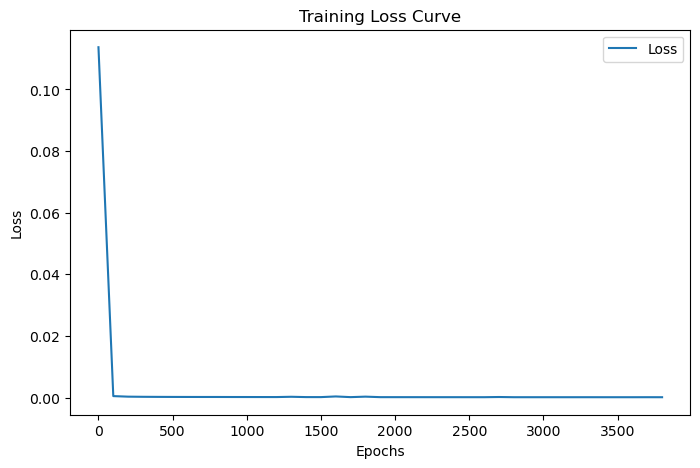

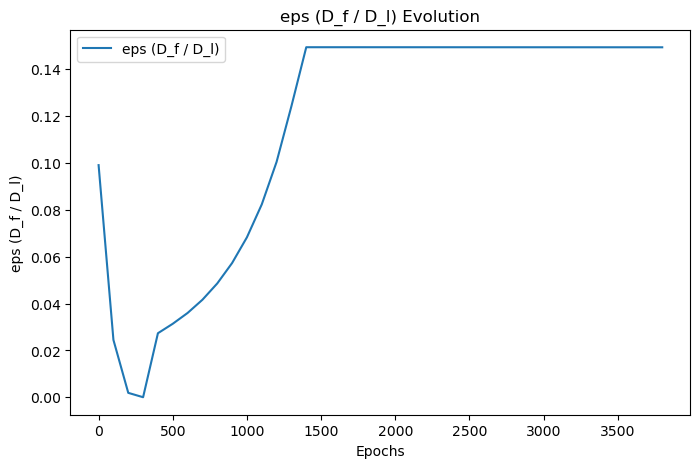

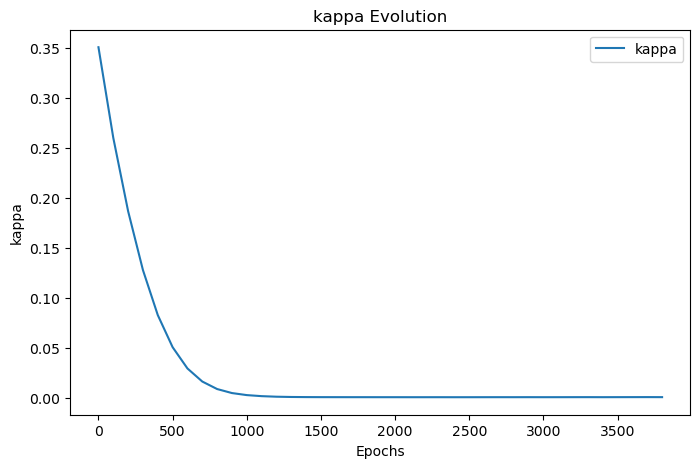

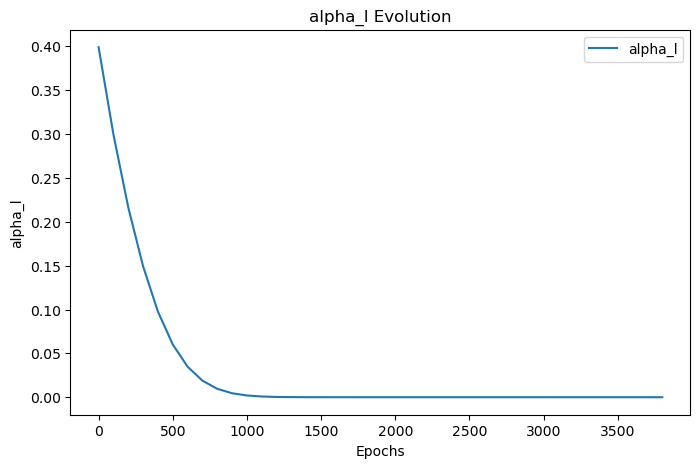

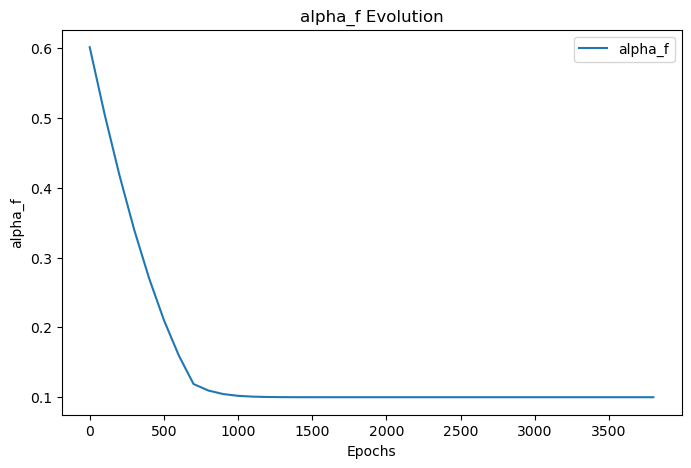

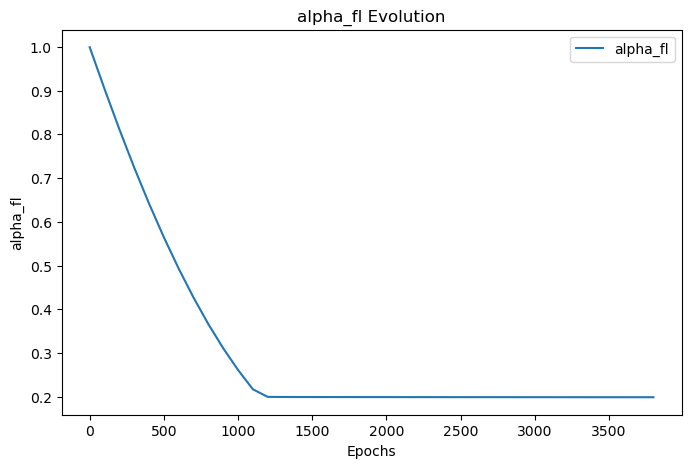

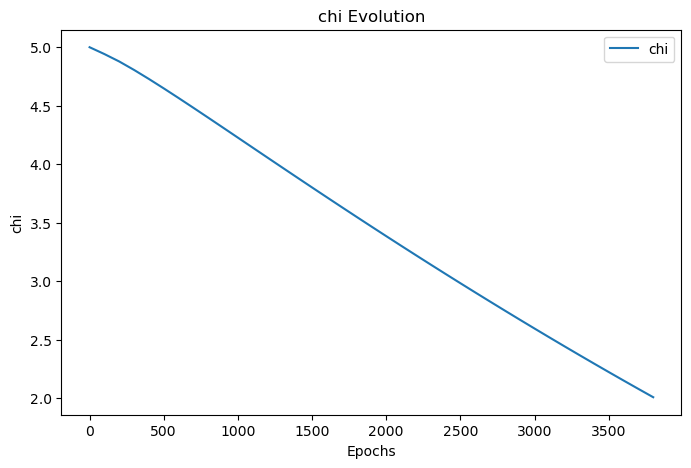

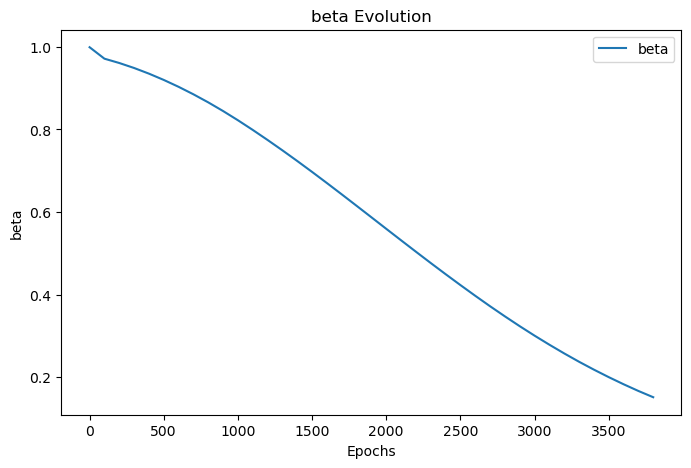

In [10]:
# Train the model
trained_model = train_pinn()
